# Script to aquire and pre-process Landsat LST data for high temperaturre days

In [1]:
## Import libraries
# system
import os
import zipfile
import time
import calendar
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import RLock
from dotenv import load_dotenv

# downloading and website scraping
import requests
from bs4 import BeautifulSoup

# aws bucket access
import boto3

# data manipulation
import yaml
import json
from thefuzz import fuzz
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio # needed to load for xarray conversions
import xarray as xr
import rioxarray as rxr
from shapely.geometry import box

# visualization
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
# import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# Load .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")

with open(f"{repo_dir}/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)

# get aws credentials
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)

## Get the boundaries of Leipzig

In [2]:
# # Define bbox for entire Leipzig
# xmin, ymin = 12.2714, 51.2705  # Southwest corner
# xmax, ymax = 12.5019, 51.4174  # Northeast corner

# # Create bbox polygon
# bbox = box(xmin, ymin, xmax, ymax)

# # Create GeoDataFrame
# bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# load from GSHL regions file
region = config.get("regions", ["Leipzig"])[0]
# region = "Leipzig"
ghsl_df_new = gpd.read_parquet(f"{repo_dir}/data/processed/ghsl_regions.parquet")
bbox_gdf = gpd.GeoDataFrame(geometry=ghsl_df_new[ghsl_df_new["region_name"]=="Leipzig"].bbox, crs="EPSG:4326")
bbox_polygon=json.loads(bbox_gdf.to_json())['features'][0]['geometry']

bbox_gdf.explore()

## Get 3-day consecutive high temperatures for the last 5 years from DWD

DWD data: 
- an overview on all german stations is available here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
- the historic daily data for each station is available for download here: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/
- for a quick search, this page displays the table interactively: https://www.dwd.de/DE/leistungen/klimadatendeutschland/klimadatendeutschland.html 

In [3]:
colnames = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]

stations_df = pd.read_fwf(
    f"{repo_dir}/data/dwd/KL_Tageswerte_Beschreibung_Stationen.txt",
    skiprows=2,
    encoding="latin1",
    names=colnames,
    dtype={"Stations_id": str} 
)

stations_df.head()

Stations_id  von_datum  bis_datum  Stationshoehe  geoBreite  geoLaenge  \
0       00001   19370101   19860630            478    47.8413     8.8493   
1       00003   18910101   20110331            202    50.7827     6.0941   
2       00011   19800901   20250224            680    47.9736     8.5205   
3       00044   19690101   20250224             44    52.9336     8.2370   
4       00052   19690101   20011231             46    53.6623    10.1990   

                  Stationsname           Bundesland Abgabe  
0                         Aach    Baden-Württemberg   Frei  
1                       Aachen  Nordrhein-Westfalen   Frei  
2  Donaueschingen (Landeplatz)    Baden-Württemberg   Frei  
3                 Großenkneten        Niedersachsen   Frei  
4         Ahrensburg-Wulfsdorf   Schleswig-Holstein   Frei

In [4]:
# stations=[{'name': 'Leipzig-Holzhausen', 'lat': 51.3151, 'lon': 12.4462, 'station_id': '02928'},
#  {'name': 'Leipzig-Mockau', 'lat': 51.392, 'lon': 12.3962, 'station_id': '02931'},
#  {'name': 'Leipzig/Halle', 'lat': 51.4347, 'lon': 12.2396, 'station_id': '02932'}]

# Get all stations for the region
stations = []
for index, row in stations_df.iterrows():
    # print("Fuzzy matching station:", row["Stationsname"], fuzz.ratio(row["Stationsname"], region))
    if fuzz.ratio(row["Stationsname"], region) > 70 or region in row["Stationsname"]:
        stations.append({
            'name': row["Stationsname"],
            'lat': row["geoBreite"],
            'lon': row["geoLaenge"],
            'date_start': pd.to_datetime(row['von_datum'], format='%Y%m%d'),
            'date_end': pd.to_datetime(row['bis_datum'], format='%Y%m%d'),
            'station_id': row["Stations_id"]
        })


stations_gpd = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy([station['lon'] for station in stations], [station['lat'] for station in stations]), crs="EPSG:4326")
stations_gpd.explore(tiles='CartoDB positron', marker_kwds={'radius': 8})

### Download the temprature data for the most urban and recent station for the region (Leipzig)

Leipzig-Mockau has data only until the 70s. Leipzig-Halle has data for the airport, which is a different environment. We, therefore, choose Leipzig-Holzhausen here to get data for a more urban environment.

The following does this selection and download programmatically to automize for other cities.

::: {.callout-note}

The coordinate system warning can be ignored, as this is only for a broad distance calculation

:::

In [5]:
end_year = config["temperature_day_filter"]["years"].get("end", 2023)
start_year = config["temperature_day_filter"]["years"].get("start", 1950)

# Get station with data in the configured year range
try:
    stations_gpd = stations_gpd[(stations_gpd['date_end'].dt.year >= end_year) & (stations_gpd['date_start'].dt.year <= start_year)]
except KeyError:
    print("No stations found for the given year range. Please check your configuration.")

# Get the center of the bbox and find the closest (most urban) station
bbox_center = bbox_gdf.geometry.centroid.iloc[0]
stations_gpd['distance'] = stations_gpd.geometry.distance(bbox_center)
stations_gpd = stations_gpd.sort_values(by='distance').reset_index(drop=True)
stations_gpd = stations_gpd.head(1)  # keep only the closest station

stations_gpd

C:\Users\janne\AppData\Local\Temp\ipykernel_71504\3988048326.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bbox_center = bbox_gdf.geometry.centroid.iloc[0]
C:\Users\janne\AppData\Local\Temp\ipykernel_71504\3988048326.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_gpd['distance'] = stations_gpd.geometry.distance(bbox_center)


name      lat      lon date_start   date_end station_id  \
0  Leipzig-Holzhausen  51.3151  12.4462 1863-12-01 2025-02-24      02928   

                  geometry  distance  
0  POINT (12.4462 51.3151)  0.074285

download the DWD data for the station (Leipzig-Holzhausen)

In [6]:
#Construct the URL for the daily DWD data
base_url= "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical"
station = stations_gpd.iloc[0]

# Download the zip and extract
foldername = f"{repo_dir}/data/dwd/{station['station_id']}_data"
if not os.path.exists(foldername):
    print(f"Requesting zip urls for {station['name']}...")
    
    #get all zip paths
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, "html.parser")

    # extract links to .zip files
    zip_files = [
        f"{base_url}/{a['href']}"
        for a in soup.find_all("a")
        if a["href"].endswith(".zip")
    ]

    # get the station specific url
    station_url = next(
        (url for url in zip_files if station['station_id'] in url), 
        None
    )
    print(f"Found station URL: {station_url}")
    
    #download the zip file
    print(f"Downloading data for {station['name']} from {station_url}")
    response = requests.get(station_url)
    
    if response.status_code == 200:
        # save zip
        with open(f"{foldername}.zip", 'wb') as f:
            f.write(response.content)
        print(f"Downloaded data for {station['name']} from {station_url}")
        
        # extract zip
        with zipfile.ZipFile(f"{foldername}.zip", 'r') as zip_ref:
            zip_ref.extractall(foldername)
        print(f"Extracted data for {station['name']} to {repo_dir}/data/dwd/")
        
        # remove zip
        os.remove(f"{foldername}.zip")
        print(f"Removed zip file {foldername}.zip")
    else:
        print(f"Failed to download data for {station['name']} from {station_url}. Status code: {response.status_code}")
else:
    print(f"Data for {station['name']} is already downloaded at {foldername}")

Data for Leipzig-Holzhausen is already downloaded at C:/Users/janne/Dropbox/Mein PC (StudiosDonPatron)/Desktop/Masters Uni Leipzig/master_thesis/masterthesis_genai_spatialplan/data/dwd/02928_data


### Read the temperature data for the station (Leipzig Holzhausen)

Metadata for the column names:
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/subdaily/standard_format/formate_kx.html

Read the data

In [7]:
files = os.listdir(foldername)
kl_file = [f for f in files if f.startswith("produkt_klima_tag") and f.endswith(".txt")]

if not kl_file:
    print(f"No climate data file found in {foldername}.")

station_kl=pd.read_csv(f"{foldername}/{kl_file[0]}", sep=";")

#trim column names
station_kl.columns = [col.strip() for col in station_kl.columns]

# date to datetime64
station_kl['MESS_DATUM'] = pd.to_datetime(station_kl['MESS_DATUM'], format="%Y%m%d")

display(station_kl.head())

#extract TXK temperature column
station_temp_max = station_kl[['MESS_DATUM','TXK']]

#replace -999.0 with NaN
station_temp_max.loc[:, 'TXK']  = station_temp_max['TXK'].replace(-999.0, np.nan)

print(f"Number of missing values in maximum temperature: {station_temp_max['TXK'].isna().sum()}")
print("Head of maximum temperature data:")
display(station_temp_max.head(3))

STATIONS_ID MESS_DATUM  QN_3     FX     FM  QN_4  RSK  RSKF    SDK  \
0         2928 1863-12-01  -999 -999.0 -999.0     1  0.1     1 -999.0   
1         2928 1863-12-02  -999 -999.0 -999.0     1  0.1     1 -999.0   
2         2928 1863-12-03  -999 -999.0 -999.0     1  6.0     1 -999.0   
3         2928 1863-12-04  -999 -999.0 -999.0     1  4.7     1 -999.0   
4         2928 1863-12-05  -999 -999.0 -999.0     1  7.6     1 -999.0   

   SHK_TAG   NM  VPM      PM  TMK   UPM  TXK  TNK    TGK  eor  
0        0  0.0  4.7  1009.0 -2.1  90.0  1.8 -4.8 -999.0  eor  
1        0  1.7  5.5   994.1 -0.8  95.0  2.9 -4.3 -999.0  eor  
2        0  6.0  7.3   985.5  4.2  89.0  5.1 -0.9 -999.0  eor  
3        0  8.0  6.4  1000.0  4.0  80.0  5.3  3.3 -999.0  eor  
4        0  7.7  7.2  1013.1  3.9  91.0  4.3  3.4 -999.0  eor

Number of missing values in maximum temperature: 1952
Head of maximum temperature data:


MESS_DATUM  TXK
0 1863-12-01  1.8
1 1863-12-02  2.9
2 1863-12-03  5.1

Plot the maximum temperature for the last 10 years

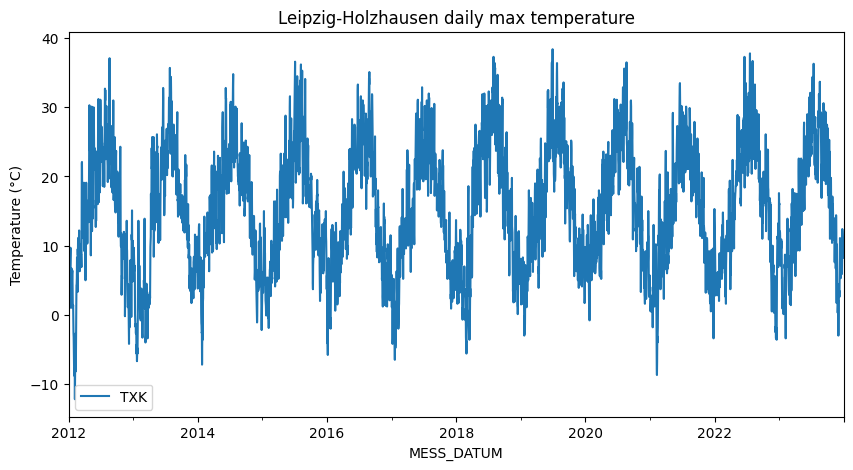

In [8]:
# last 10 years
last_10_all = station_temp_max.set_index('MESS_DATUM').loc['2012-01-01':'2023-12-31']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
last_10_all.plot(ax=ax)
ax.set_title("Leipzig-Holzhausen daily max temperature")
ax.set_ylabel("Temperature (°C)")
plt.show()

### Get three consecutive days with high temperatures

In [9]:
# min_temperature=25 #30
min_temperature = config["temperature_day_filter"]["min"]
consecutive_days = config["temperature_day_filter"]["consecutive_days"]

# summed days with max temperature >= min_temperature for rolling window of 3 days
station_temp_max.loc[:, 'gt_roll']=station_temp_max['TXK'].ge(min_temperature).rolling(window=consecutive_days).sum()

# get only the days where the rolling window is equal to the number of consecutive days
station_temp_max_gt=station_temp_max[station_temp_max['gt_roll'] == consecutive_days].copy()
station_temp_max_gt

C:\Users\janne\AppData\Local\Temp\ipykernel_71504\2591477793.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_temp_max.loc[:, 'gt_roll']=station_temp_max['TXK'].ge(min_temperature).rolling(window=consecutive_days).sum()


MESS_DATUM   TXK  gt_roll
539   1865-05-23  28.5      3.0
540   1865-05-24  28.8      3.0
584   1865-07-07  32.4      3.0
585   1865-07-08  29.1      3.0
586   1865-07-09  26.9      3.0
...          ...   ...      ...
53238 2024-09-04  34.9      3.0
53239 2024-09-05  32.5      3.0
53240 2024-09-06  31.2      3.0
53241 2024-09-07  31.2      3.0
53242 2024-09-08  32.2      3.0

[2372 rows x 3 columns]

Function to plot the days with a rolling window mean

In [10]:
def plotTemperatureYearGt(selected_start_year, selected_end_year):
    global station_temp_max, station_temp_max_gt, min_temperature, consecutive_days
    
    # rolling 3-day mean
    station_temp_max_rolling = station_temp_max[["MESS_DATUM", "TXK"]].set_index('MESS_DATUM').rolling(window=3).mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    station_temp_max_rolling.loc[f'{selected_start_year}-01-01':f'{selected_end_year}-12-31'].plot(ax=ax)
    
    gt_consecutive_day_points=station_temp_max_gt[station_temp_max_gt['MESS_DATUM'].dt.year>=selected_start_year]
    gt_consecutive_day_points=gt_consecutive_day_points[gt_consecutive_day_points['MESS_DATUM'].dt.year<=selected_end_year]
    
    if not gt_consecutive_day_points.empty:
        gt_consecutive_day_points.plot(x='MESS_DATUM', y='TXK', style='ro', ax=ax, label=f'Heat Days (>= {min_temperature}°C)')
    ax.set_title("Leipzig-Holzhausen daily max temperature")
    ax.set_ylabel("Temperature (°C)")
    plt.show()

Plot for 2018-2013

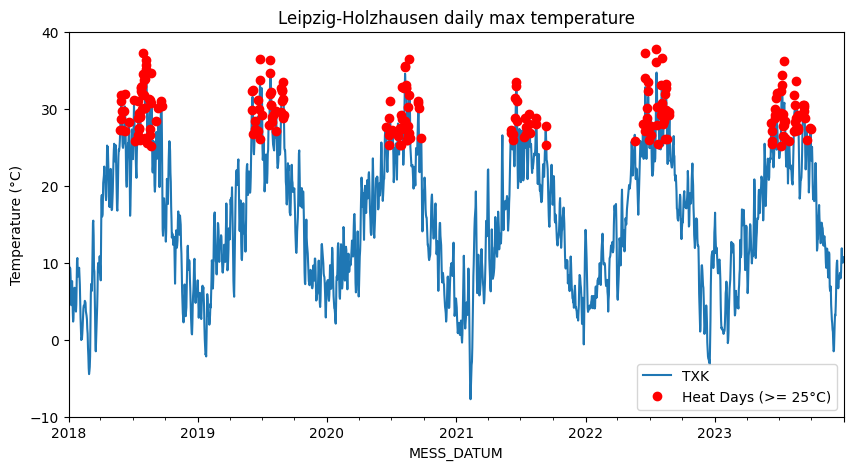

In [11]:
plotTemperatureYearGt(2018, 2023)

Plot for a single year 2020

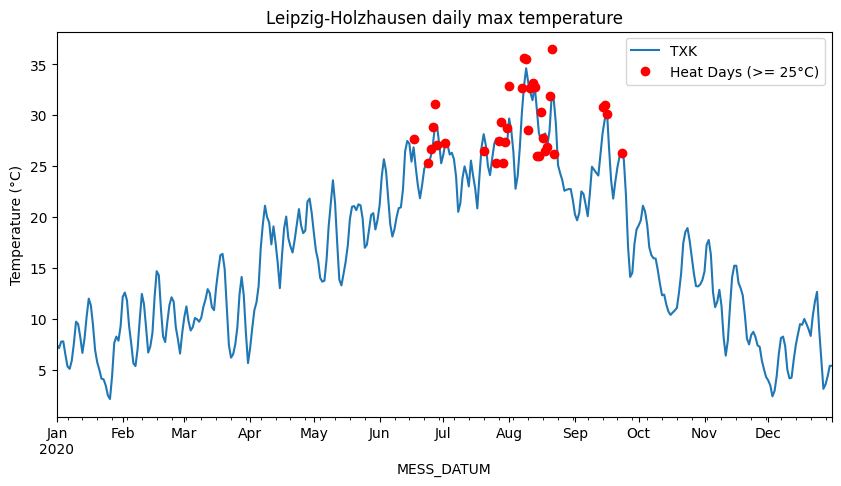

In [12]:
plotTemperatureYearGt(2020, 2020)

## Get LST Data from Landsat

How to query the stac api: https://code.usgs.gov/eros-user-services/quick-guides/querying-the-stac-api-with-geojson-objects/-/blob/main/querying_with_geojson_objects_v3.ipynb?ref_type=heads


Further information on the post requests can be found on the node api documentation:
https://github.com/stac-utils/stac-server

Here a sample post request to get the data for a bounding box and a specific date range, with cloud cover filter:
```bash	
curl -X "POST" "${HOST}/search" \
     -H 'Content-Type: application/json; charset=utf-8' \
     -d $'{
  "collections": [
    "sentinel-2-l2a",
    "sentinel-2-l1c"
  ],
  "bbox": [
    10,
    10,
    15,
    15
  ],
  "query": {
    "eo:cloud_cover": {
      "gte": 0,
      "lte": 5
    }
  },
  "filter": {
    "op": "<",
    "args": [
      "property": "view:sun_elevation"
    ],
    50
  }
  "sortby": {
    "field": "properties.datetime",
    "direction": "desc"
  }
}'
```

Function to query the stac server for features with boundary geolocation:

In [13]:
def fetch_stac_server(query):
    '''
    Queries the stac-server (STAC) backend.
    query is a python dictionary to pass as json to the request.
    '''
    
    search_url = f"https://landsatlook.usgs.gov/stac-server/search"
    query_return = requests.post(search_url, json=query).json()
    error = query_return.get("message", "")
    if error:
        raise Exception(f"STAC-Server failed and returned: {error}")
        
    if 'code' in query_return: # if query fails, return failure code
        print(query_return)   
    else:
        features = query_return['features']
        #print(f"{len(features)} STAC items found")
        if len(features) > 0:
            #print(f"first feature: {features[0]}")
            
            query_gdf = gpd.GeoDataFrame.from_features(features, crs="EPSG:4326")
            query_gdf['assets'] = [ 
                feature["assets"]
                for feature in features
            ]
            query_gdf['description'] = [feature["description"] for feature in features]
            query_gdf['stac_id']= [feature["id"] for feature in features]

            return query_gdf
        else:
            #print("No features found")
            return None

Function to send a a filtered request to the stac server using the function above:

In [14]:
def send_STAC_query(limit=200, collections='landsat-c2l2-sr', intersects=None, year:str=None, month:str=None, date_list:list[str]=None, max_cloud_cover=None):
    '''
    This function helps to create a simple parameter dictionary for querying 
    the Landsat Collection 2 Level 2 Surface Reflectance feature in the STAC Server.
    It prints the parameter dictionary and returns the query results.
    
    args:
    limit: int, default 200, number of items to return
    collections: str, default 'landsat-c2l2-sr', collection to query
    intersects: dict, default None, geometry to intersect with
    year: str, default None, year to filter by
    month: str, default None, month to filter by in format '01'
    date_list: list, default None, list of dates (YYYY-MM-DD) to filter by
    '''
    params = {}
    if limit is not None:
        params['limit'] = limit
    
    if collections is not None:
        params['collections'] = collections
        
    if intersects is not None:
        params['intersects'] = intersects
        
    if max_cloud_cover is not None:
        params['query'] = {
            "eo:cloud_cover": {
                "lte": max_cloud_cover
            }
        }
        
    #filter by date
    if date_list is not None:
        formatted_dates = [f"{date}T00:00:00Z" for date in date_list]
        params["datetime"] = ",".join(formatted_dates)

        all_results = []

        for date in date_list:
            params["datetime"] = f"{date}T00:00:00Z/{date}T23:59:59Z"
            
            #print(f"Querying STAC for date: {date}")
            result = fetch_stac_server(params)

            if result is not None:
                all_results.append(result)

        if all_results:
            return gpd.pd.concat(all_results, ignore_index=True)
        else:
            return None
        
    else:
        max_day = 31
        
        if year is not None:
            params['datetime'] = f"{year}-01-01T00:00:00Z/{year}-12-31T23:59:59Z"
        if month is not None:
            #set last day for month
            max_day=calendar.monthrange(int(year), int(month))[1]
            
            params['datetime'] = f"1970-{month}-01T00:00:00Z/2024-{month}-{max_day}T23:59:59Z"
        if year is not None and month is not None:        
            params['datetime'] = f"{year}-{month}-01T00:00:00Z/{year}-{month}-{max_day}T23:59:59Z"
        
        print(params) 
        
        return fetch_stac_server(params)

A sample request for the first 20 features for Leipzig in the year 2020 for landsat collection "landsat-c2l2-sr" for a cloud cover of max 10%:

In [15]:
query_gdf = send_STAC_query(intersects=bbox_polygon, limit=20, year='2020', max_cloud_cover=10) #,month='06') #,date_list=['2020-01-01', '2022-10-14'])
display(query_gdf.head(2))
query_gdf.explore(fill=0)

{'limit': 20, 'collections': 'landsat-c2l2-sr', 'intersects': {'type': 'Polygon', 'coordinates': [[[12.504129909612955, 51.26216406790087], [12.504129909612955, 51.40691028331796], [12.244877029138685, 51.40691028331796], [12.244877029138685, 51.26216406790087], [12.504129909612955, 51.26216406790087]]]}, 'query': {'eo:cloud_cover': {'lte': 10}}, 'datetime': '2020-01-01T00:00:00Z/2020-12-31T23:59:59Z'}


geometry  \
0  POLYGON ((11.60771 52.70136, 10.95144 51.12372...   
1  POLYGON ((10.32634 52.76083, 9.61106 51.06248,...   

                      datetime  eo:cloud_cover  view:sun_azimuth  \
0  2020-09-22T09:28:22.627792Z            0.00        151.110589   
1  2020-09-21T10:09:24.616081Z            0.06        161.533895   

   view:sun_elevation   platform  instruments  view:off_nadir  \
0           34.715601  LANDSAT_7        [ETM]               0   
1           37.293792  LANDSAT_8  [OLI, TIRS]               0   

   landsat:cloud_cover_land landsat:wrs_type  ... proj:epsg    proj:shape  \
0                      0.00                2  ...     32633  [7591, 8511]   
1                      0.06                2  ...     32632  [7881, 7781]   

                     proj:transform card4l:specification  \
0  [30, 0, 209985, 0, -30, 5846715]                   SR   
1  [30, 0, 541185, 0, -30, 5847015]                   SR   

  card4l:specification_version                   created  \
0                          5.0  2022-07-01T03:39:39.759Z   
1                          5.0  2022-07-01T03:45:20.027Z   

                    updated  \
0  2022-07-01T03:39:39.759Z   
1  2022-07-01T03:45:20.027Z   

                                              assets  \
0  {'thumbnail': {'title': 'Thumbnail image', 'ty...   
1  {'thumbnail': {'title': 'Thumbnail image', 'ty...   

                                         description  \
0  Landsat Collection 2 Level-2 Surface Reflectan...   
1  Landsat Collection 2 Level-2 Surface Reflectan...   

                                       stac_id  
0  LE07_L2SP_193024_20200922_20201018_02_T1_SR  
1  LC08_L2SP_194024_20200921_20201006_02_T1_SR  

[2 rows x 31 columns]

### Query for the high temperature days

Get the last five years of consecutive high temperatures for day 2 and 3 in a compatible date format

In [16]:
station_temp_max_gt=station_temp_max_gt[station_temp_max_gt.MESS_DATUM.dt.year>=start_year].copy()
station_temp_max_gt_dates=station_temp_max_gt.MESS_DATUM.to_list()

# get the day before each third day as well
station_temp_max_gt_dates_before=[date - pd.DateOffset(days=1) for date in station_temp_max_gt_dates]

# merge the two lists
station_temp_max_gt_dates.extend(station_temp_max_gt_dates_before)

# sort the list
station_temp_max_gt_dates.sort()

# remove duplicates
station_temp_max_gt_dates=list(dict.fromkeys(station_temp_max_gt_dates))

# get dates in format YYYY-MM-DD
station_temp_max_gt_dates=[date.strftime("%Y-%m-%d") for date in station_temp_max_gt_dates]
station_temp_max_gt_dates[-6:]

['2024-09-03',
 '2024-09-04',
 '2024-09-05',
 '2024-09-06',
 '2024-09-07',
 '2024-09-08']

Query for the dates using multithreaded requests

In [17]:
chunk_size=20
chunks=[station_temp_max_gt_dates[i:i + chunk_size] for i in range(0, len(station_temp_max_gt_dates), chunk_size)]

max_cloud_cover = config["landsat_query"].get("max_cloud_coverage", 10)
collections = config["landsat_query"].get("collections", ["landsat-c2l2-st"])

query_gdf = gpd.pd.DataFrame()

# multithread requests using tqdm progress bar
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(send_STAC_query, intersects=bbox_polygon, limit=1, date_list=chunk, collections=collections, max_cloud_cover=max_cloud_cover) for chunk in chunks]
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            if len(result) > 0:
                query_gdf = gpd.pd.concat([query_gdf, result], ignore_index=True)


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


save as geoparquet

In [18]:
landsat_region_folder = f"{repo_dir}/data/landsat/{region.lower()}"
os.makedirs(landsat_region_folder, exist_ok=True)

stac_filename = f"{landsat_region_folder}/stac_query_ge{min_temperature}_cc{max_cloud_cover}_{start_year}_{end_year}.parquet"
if not os.path.exists(stac_filename):
    print(f"Saving STAC query results to {stac_filename}")
    query_gdf.to_parquet(stac_filename)
    print(f"Saved STAC query results to {stac_filename}")
else:
    print(f"STAC query results already exist at {stac_filename}")

Saving STAC query results to C:/Users/janne/Dropbox/Mein PC (StudiosDonPatron)/Desktop/Masters Uni Leipzig/master_thesis/masterthesis_genai_spatialplan/data/landsat/leipzig/stac_query_ge25_cc10_2018_2022.parquet
Saved STAC query results to C:/Users/janne/Dropbox/Mein PC (StudiosDonPatron)/Desktop/Masters Uni Leipzig/master_thesis/masterthesis_genai_spatialplan/data/landsat/leipzig/stac_query_ge25_cc10_2018_2022.parquet


In [19]:
query_gdf=gpd.read_parquet(stac_filename)
query_gdf.explore()

## Get the images for the requested collection information

In the previous step, the metadata for the images was queried. Now, the images can be downloaded using the asset links.

For information on the asset links:
https://landsat.usgs.gov/stac/LC09_L2SP_095022_20220625_20220627_02_T1_ST_stac.json

```python
assets=requests.get('https://landsat.usgs.gov/stac/LC09_L2SP_095022_20220625_20220627_02_T1_ST_stac.json').json()['assets']
assets
```

We also stored them in the geodataframe:

In [20]:
pd.DataFrame(query_gdf.iloc[0].assets)

ANG.txt  \
alternate                 {'s3': {'href': 's3://usgs-landsat/collection0...   
description               Collection 2 Level-2 Angle Coefficients File (...   
file:checksum             134086bf4b3136acd1f10a2af16c0705febd9e8d6f6cc0...   
href                      https://landsatlook.usgs.gov/data/collection02...   
roles                                                            [metadata]   
title                                               Angle Coefficients File   
type                                                             text/plain   
eo:bands                                                                NaN   
classification:bitfields                                                NaN   

                                                                      ATRAN  \
alternate                 {'s3': {'href': 's3://usgs-landsat/collection0...   
description               Collection 2 Level-2 Atmospheric Transmittance...   
file:checksum             1340bec1333317bac18ecff60ef13e5be402548630b2c3...   
href                      https://landsatlook.usgs.gov/data/collection02...   
roles                                                                [data]   
title                                        Atmospheric Transmittance Band   
type                           image/vnd.stac.geotiff; cloud-optimized=true   
eo:bands                                                                NaN   
classification:bitfields                                                NaN   

                                                                      CDIST  \
alternate                 {'s3': {'href': 's3://usgs-landsat/collection0...   
description               Collection 2 Level-2 Cloud Distance Band Surfa...   
file:checksum             134077d4a18791b1e9f91a52984846164e066fe58de17b...   
href                      https://landsatlook.usgs.gov/data/collection02...   
roles                                                                [data]   
title                                                   Cloud Distance Band   
type                           image/vnd.stac.geotiff; cloud-optimized=true   
eo:bands                                                                NaN   
classification:bitfields                                                NaN   

                                                                       DRAD  \
alternate                 {'s3': {'href': 's3://usgs-landsat/collection0...   
description               Collection 2 Level-2 Downwelled Radiance Band ...   
file:checksum             13404f3491d3833d92debadcf9007e8f4c1da2dc0d0f45...   
href                      https://landsatlook.usgs.gov/data/collection02...   
roles                                                                [data]   
title                                              Downwelled Radiance Band   
type                           image/vnd.stac.geotiff; cloud-optimized=true   
eo:bands                                                                NaN   
classification:bitfields                                                NaN   

                                                                       EMIS  \
alternate                 {'s3': {'href': 's3://usgs-landsat/collection0...   
description               Collection 2 Level-2 Emissivity Band Surface T...   
file:checksum             134079abe705e93cbe365e6656cc027d1cf59fe255f022...   
href                      https://landsatlook.usgs.gov/data/collection02...   
roles                                                                [data]   
title                                                       Emissivity Band   
type                           image/vnd.stac.geotiff; cloud-optimized=true   
eo:bands                                                                NaN   
classification:bitfields                                                NaN   

                                                                       EMSD  \
alternate                 {'s3': {

To pre-process the LST data correctly, the QA bands from Landsat should be considered as well:

| QA Band | What it contains | Primary purpose |
|---------|------------------|-----------------|
| qa (ST_QA) | Basic surface temperature QA | Indicates confidence in the ST retrieval (based on conditions like cloud cover, emissivity, etc.) |
| qa_pixel (QA_PIXEL) | Full pixel quality assessment | Provides cloud, snow, water, and cirrus flags — very useful for masking out unreliable pixels. |
| qa_radsat (QA_RADSAT) | Radiometric saturation QA | Tells if specific spectral bands are saturated — typically important for reflectance bands, less so for LST. |

### Request the product urls

In [21]:
def getLandsatTemperatureProducts(query_gdf):
    '''
    This function retrieves the Landsat 8 Surface Temperature products from the query results.
    It returns a list of the product urls.
    '''
    products = []
    for index, row in query_gdf.iterrows():
        assets = row.assets
        if 'lwir11' in assets and assets['lwir11'] is not None:
            products.append({"stac_id": row.stac_id, "datetime": row.datetime,
                             "thermal": {
                             "url": assets['lwir11']['href'],
                             "alternate": assets['lwir11']['alternate']},
                            "qa_pixel":{"url": assets['qa_pixel']['href'], "alternate": assets['qa_pixel']['alternate']}
                            })
                            
        elif 'lwir' in assets and assets['lwir'] is not None:
            print(f"found only B6 from Landsat 7 for {row.stac_id}")
            # products.append({"stac_id": row.stac_id, "datetime": row.datetime, 
                            #  "url": assets['lwir']['href'], "alternate": assets['lwir']['alternate']})
            
        else:
            print(f"No lwir11 asset for {row.stac_id}")

    return products

products=getLandsatTemperatureProducts(query_gdf)
pd.DataFrame(products[0])

found only B6 from Landsat 7 for LE07_L2SP_194024_20190725_20200825_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_194024_20190826_20200824_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20200922_20201018_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_194024_20180807_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20180816_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_194024_20180823_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20180528_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20180715_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20180731_20200829_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_194024_20200812_20200915_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20200821_20200917_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_194024_20190623_20200825_02_T1_ST
found only B6 from Landsat 7 for LE07_L2SP_193024_20220703_20220903_02_T1_ST

stac_id  \
url        LC08_L2SP_193024_20190726_20200827_02_T1_ST   
alternate  LC08_L2SP_193024_20190726_20200827_02_T1_ST   

                              datetime  \
url        2019-07-26T10:02:57.950004Z   
alternate  2019-07-26T10:02:57.950004Z   

                                                     thermal  \
url        https://landsatlook.usgs.gov/data/collection02...   
alternate  {'s3': {'href': 's3://usgs-landsat/collection0...   

                                                    qa_pixel  
url        https://landsatlook.usgs.gov/data/collection02...  
alternate  {'s3': {'href': 's3://usgs-landsat/collection0...

### Download the images using AWS CLI

In [22]:
# Setup tqdm lock to prevent corruption of output
tqdm.set_lock(RLock())

# Setup the boto3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-west-2'
)

def parse_s3_url(s3_url):
    if s3_url.startswith("s3://"):
        s3_url = s3_url[5:]
    bucket, key = s3_url.split("/", 1)
    return bucket, key

class TqdmFileWrapper:
    def __init__(self, fileobj, tqdm_bar):
        self.fileobj = fileobj
        self.tqdm_bar = tqdm_bar

    def write(self, data):
        self.fileobj.write(data)
        self.tqdm_bar.update(len(data))

    def close(self):
        self.fileobj.close()

def download_tif(s3_url, local_path, position=0):
    bucket, key = parse_s3_url(s3_url)

    # Find out the file size
    head = s3.head_object(Bucket=bucket, Key=key, RequestPayer='requester')
    file_size = head['ContentLength']

    # Setup tqdm progress bar
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=f"Downloading {os.path.basename(local_path)}", position=position) as pbar:
        with open(local_path, 'wb') as f:
            wrapped_file = TqdmFileWrapper(f, pbar)
            s3.download_fileobj(
                Bucket=bucket,
                Key=key,
                Fileobj=wrapped_file,
                ExtraArgs={'RequestPayer': 'requester'}
            )


def requestProduct(product, region, position=0):
    '''
    This function retrieves the products from the USGS server and saves it to the output path.
    It stores both the thermal and the qa_pixel tif files.
    '''
    
    landsat_region_folder = f"{repo_dir}/data/landsat/{region.lower()}"
    os.makedirs(f"{landsat_region_folder}/landsat_temperature", exist_ok=True)
    output_path_base = f"{landsat_region_folder}/landsat_temperature/{product['stac_id']}"
    output_path_thermal = f"{output_path_base}_thermal.tif"
    output_path_qa_pixel = f"{output_path_base}_qa_pixel.tif"
    
    if not os.path.exists(output_path_thermal):
        os.makedirs(os.path.dirname(output_path_thermal), exist_ok=True)
        s3_url = product["thermal"]['alternate']['s3']['href']
        download_tif(s3_url, output_path_thermal, position)

    if not os.path.exists(output_path_qa_pixel):
        os.makedirs(os.path.dirname(output_path_qa_pixel), exist_ok=True)
        s3_url = product["qa_pixel"]['alternate']['s3']['href']
        download_tif(s3_url, output_path_qa_pixel, position + 1)

    return

requestProduct(products[0], region)

Thread download all the datasets

In [ ]:
def process_all_products(products, max_workers=8):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(requestProduct, product, region, i*2): product
            for i, product in enumerate(products, start=1)
        }


process_all_products(products)

## Pre-process the data

Open the first file to plot and clip to bbox

In [94]:
files=os.listdir(f"{landsat_region_folder}/landsat_temperature")
files=[file for file in files if file.startswith("LC08")]
files=[f"{landsat_region_folder}/landsat_temperature/{file}" for file in files]

thermal_files=[file for file in files if file.endswith("thermal.tif")]
qa_pixel_files=[file for file in files if file.endswith("qa_pixel.tif")]

xds = rxr.open_rasterio(thermal_files[0])

# transform bbox crs
bbox_gdf_utm = bbox_gdf.to_crs(xds.rio.crs)

#clip to bbox
xds = xds.rio.clip([bbox_gdf_utm.geometry.iloc[0]], bbox_gdf_utm.crs)

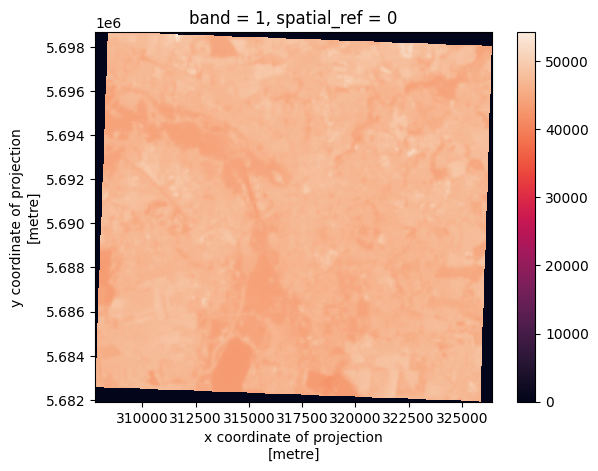

In [95]:
xds.plot(cmap=rocket)

Assessing the quality band

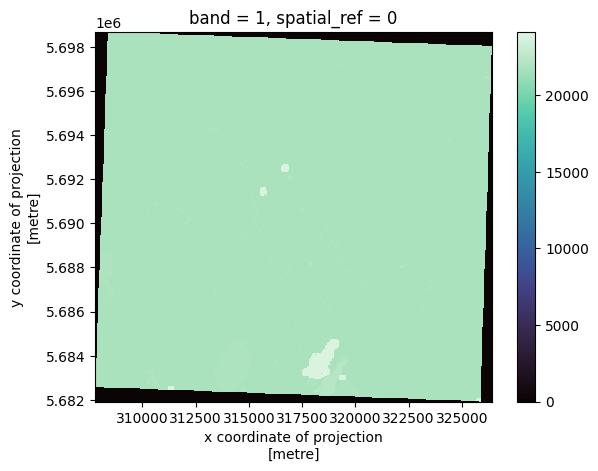

In [96]:
xds_qa = rxr.open_rasterio(qa_pixel_files[0])
# xds_qa = xds_qa.astype("float32")
xds_qa = xds_qa.rio.write_nodata(0, inplace=True)
xds_qa = xds_qa.rio.clip([bbox_gdf_utm.geometry.iloc[0]], bbox_gdf_utm.crs)
xds_qa.plot(cmap=mako)

Define a cloud shadow mask

In [97]:
# Define bit positions for cloud and cloud shadow
CLOUD_SHADOW_BIT = 3  # Bit 3 = cloud shadow
CLOUD_BIT = 5         # Bit 5 = cloud

# Create masks
cloud_shadow_mask = (xds_qa & (1 << CLOUD_SHADOW_BIT)) == 0  # True = no shadow
cloud_mask = (xds_qa & (1 << CLOUD_BIT)) == 0                 # True = no cloud

clear_mask = cloud_shadow_mask & cloud_mask
xds_qa = clear_mask.astype(np.uint8)

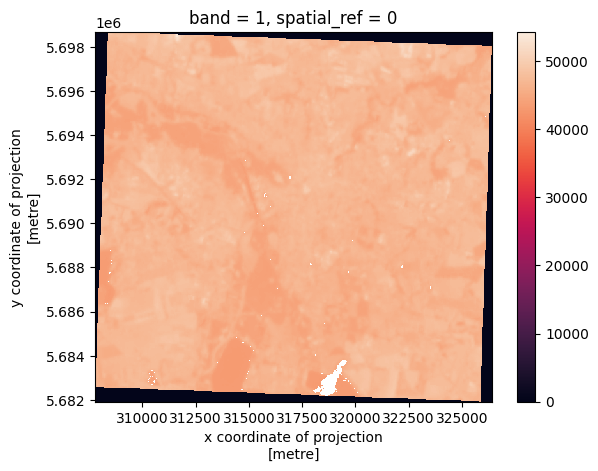

In [98]:
xds.where(xds_qa).plot(cmap=rocket)

To obtain actual temperature values, the Landsat specific scale and offset values need to be applied to the data, like indicated here: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products

A good tutorial on how to process satellite imagery: https://medium.com/@ridhomuh002/analyzing-land-surface-temperature-lst-with-landsat-8-data-in-google-earth-engine-f4dd7ca28e70

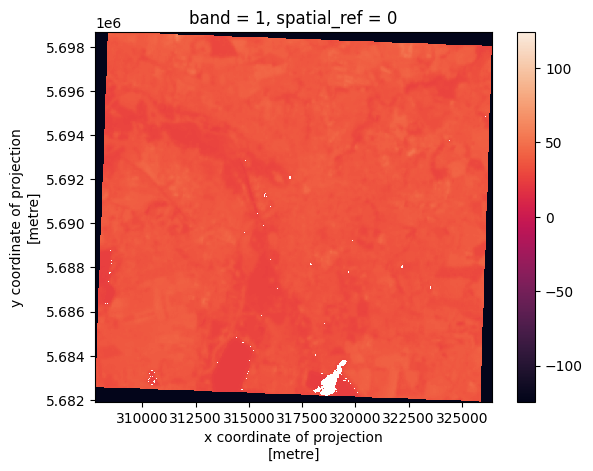

In [99]:
scale_factor=0.00341802
add_offset=149.0-273.15
xds_new=xds*scale_factor+add_offset

xds_new.where(xds_qa).plot(cmap=rocket)

## Create a processed zarr for the Landsat data

In [110]:
#### create landsat zarr ###

#read files
files=os.listdir(f"{landsat_region_folder}/landsat_temperature")
files=[file for file in files if file.startswith("LC08")]
file_paths=[f"{landsat_region_folder}/landsat_temperature/{file}" for file in files]
thermal_file_paths=[file for file in file_paths if file.endswith("thermal.tif")]
qa_pixel_file_paths=[file for file in file_paths if file.endswith("qa_pixel.tif")]

# find qa pixel files for thermal files and create set of file paths
file_sets=[]
for thermal_file in thermal_file_paths:
    qa_pixel_file=thermal_file.replace("thermal", "qa_pixel")
    if qa_pixel_file in qa_pixel_file_paths:
        file_sets.append([qa_pixel_file, thermal_file])

# find file in query_gdf
def find_file(stac_id):
    return query_gdf[query_gdf['stac_id']==stac_id].iloc[0]

# read file function with metadata attached
def readLandsatTifsToXarrayDS(ds_file_path_set):
    """
    Read Landsat tif files to xarray dataset and attach metadata.
    
    args:
    file_path: str, path to the tif file    
    """
    
    thermal_file_path=ds_file_path_set[1]
    qa_pixel_file_path=ds_file_path_set[0]
    
    if not os.path.exists(thermal_file_path):
        print(f"File not found: {thermal_file_path}")
        return None
    if not os.path.exists(qa_pixel_file_path):
        print(f"File not found: {qa_pixel_file_path}")
        return None
    
    #####create thermal data array######
    #read file
    xda=rxr.open_rasterio(thermal_file_path, masked=True)
    xda = xda.rio.reproject("EPSG:4326")
    
    #clip to bbox
    xda = xda.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)
    
    # apply scaling factor to degrees celsius
    scale_factor=0.00341802
    add_offset=149.0-273.15
    #xda=xda*scale_factor+add_offset
    xda.attrs['scale_factor']=scale_factor
    xda.attrs['add_offset']=add_offset
    
    #rename data array
    xda=xda.rename('surface_temp_b10')
    
    
    #####create qa pixel data array#######
    #read file
    xda_qa=rxr.open_rasterio(qa_pixel_file_path)
    
    # fill nodata values with 0
    xda_qa = xda_qa.rio.write_nodata(0, inplace=True)
    xda_qa = xda_qa.rio.reproject("EPSG:4326")
    
    #clip to bbox
    xda_qa = xda_qa.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)
    
    #mask cloud and cloud shadow
    # Define bit positions for cloud and cloud shadow
    CLOUD_SHADOW_BIT = 3  # Bit 3 = cloud shadow
    CLOUD_BIT = 5         # Bit 5 = cloud

    # Create masks
    cloud_shadow_mask = (xda_qa & (1 << CLOUD_SHADOW_BIT)) == 0  # True = no shadow
    cloud_mask = (xda_qa & (1 << CLOUD_BIT)) == 0                 # True = no cloud

    clear_mask = cloud_shadow_mask & cloud_mask
    xda_qa = clear_mask.astype(np.uint8)
    
    #rename data array
    xda_qa=xda_qa.rename('qa_pixel')
    
    
    #####create masked array #####
    #create masked array
    xda_mask=xda.where(xda_qa)
    
    #rename data array
    xda_mask=xda_mask.rename('surface_temp_b10_masked')
    
    
    #####combine data arrays####
    xds=xr.merge([xda, xda_qa, xda_mask])
    
    
    #####add metadata#####
    # get stac data
    stac_id=thermal_file_path.split("/")[-1].split(".")[0].split("_thermal")[0]
    file=find_file(stac_id)
    date=file.datetime
    
    #add general metadata
    xds.attrs['title']="Landsat 8 Surface Temperature"
    xds.attrs['description']="Landsat 8 Surface Temperature data from USGS for specific hot days (3 continous >30C° days) in Leipzig"
    xds.attrs['source']="USGS"
    xds.attrs['crs']="EPSG:4326"
    xds.attrs['bbox']=bbox_gdf.to_json()
    xds.attrs['variables']={"surface_temp_b10": "Surface Temperature Band (B10)",
                            "qa_pixel": "Quality Assessment Pixel",
                            "surface_temp_b10_masked": "Surface Temperature Band (B10) Masked"}
    xds.attrs['units']={"surface_temp_b10": "°C", "qa_pixel": "1", "surface_temp_b10_masked": "°C"}
    
    #remove scale_factor and add_offset from attrs
    xds.attrs.pop('scale_factor', None)
    xds.attrs.pop('add_offset', None)
    
    #remove spatial_ref and band coords
    xds=xds.drop_vars(["spatial_ref", "band"])
    
    #squeeze band from variables
    xds=xds.squeeze("band", drop=True)
    
    # add time coordinate
    xds=xds.expand_dims(time=[date])
    # xds=xds.expand_dims(stac_id=[stac_id])
    # xds=xds.expand_dims(view_sun_elevation=[file['view:sun_elevation']])
    # xds=xds.expand_dims(view_sun_azimuth=[file['view:sun_azimuth']])
    # xds=xds.expand_dims(view_off_nadir=[file['view:off_nadir']])

    #add metadata as variables over time
    xds['stac_id']=xr.DataArray([stac_id], dims=['time'])
    xds['view_sun_elevation']=xr.DataArray([file['view:sun_elevation']], dims=['time'])
    xds['view_sun_azimuth']=xr.DataArray([file['view:sun_azimuth']], dims=['time'])
    xds['view_off_nadir']=xr.DataArray([file['view:off_nadir']], dims=['time'])

    return xds

# read all files
xds_list=[readLandsatTifsToXarrayDS(file_set) for file_set in file_sets]
#landsat_xr_ds=readLandsatTifsToXarrayDS(file_sets[0])

The coordinates of the products do not align perfectly:

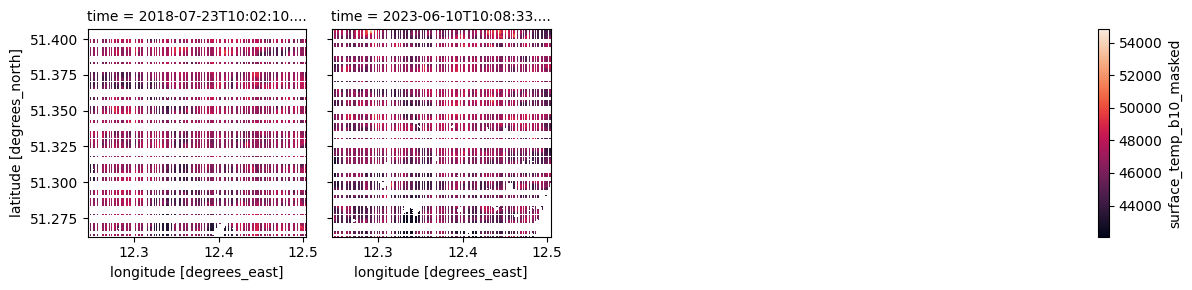

In [111]:
test1 = xds_list[0]
test2 = xds_list[10]
test_concat_xr = xr.concat([test1, test2], dim='time')

test_concat_xr.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

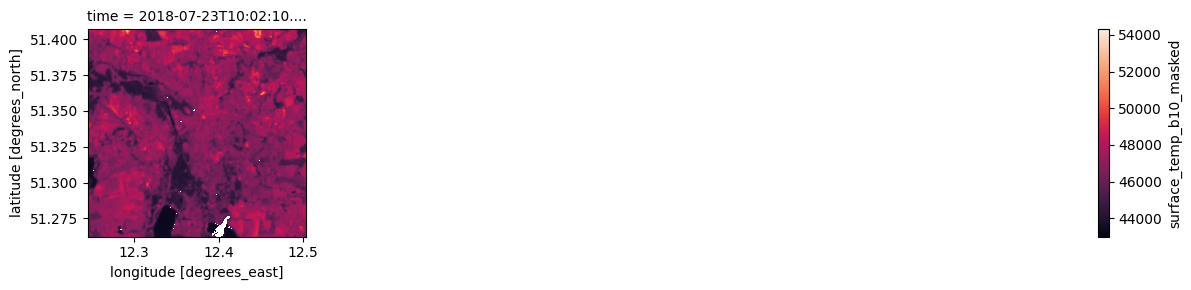

In [112]:
test1.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

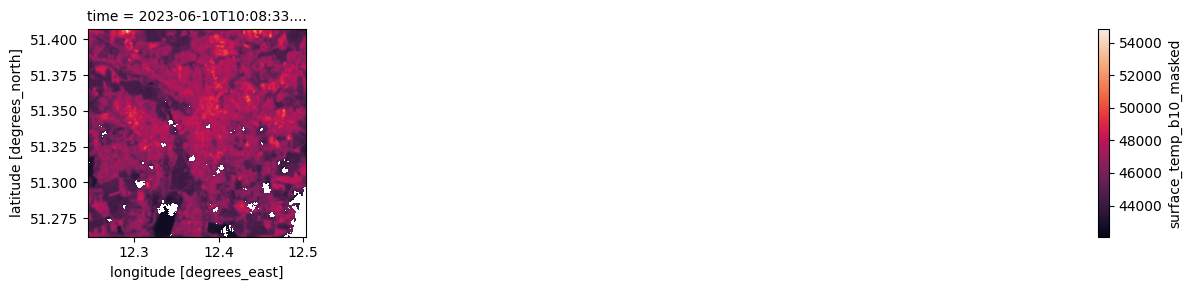

In [113]:
test2.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

Therefore, the coordinates should be be reindexed to a template grid before concatenating the data, so the data aligns.

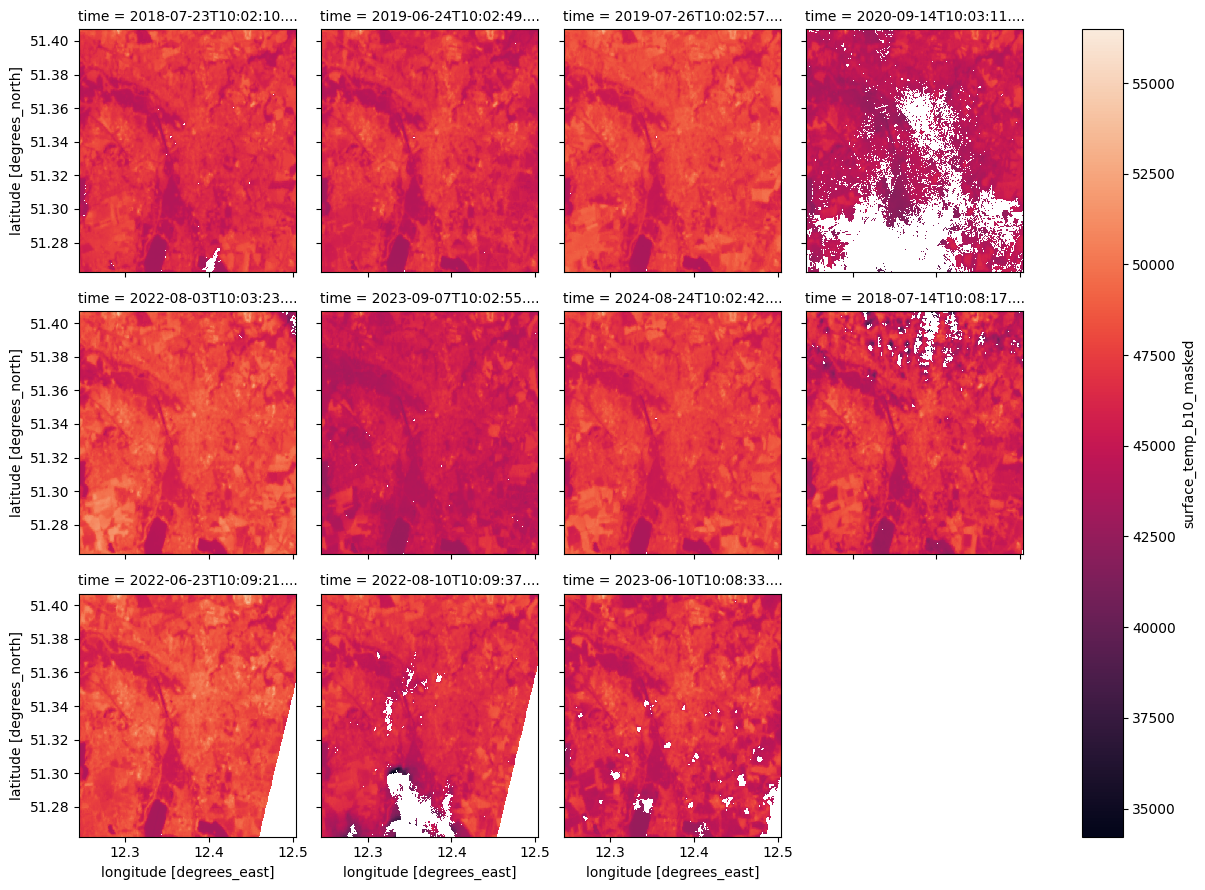

In [132]:
common_x = xds_list[0].x
common_y = xds_list[0].y

xds_list = [
    ds.reindex(x=common_x, y=common_y, method="nearest")  # or method="pad"
    for ds in xds_list
]

#combine datasets
landsat_xr_ds=xr.concat(xds_list, dim='time')
landsat_xr_ds.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

Somehow the stac filtering did not work on all files, so a second filter is applied here to remove all files where the qa_pixel is not null more than the allowed configuration percentage.

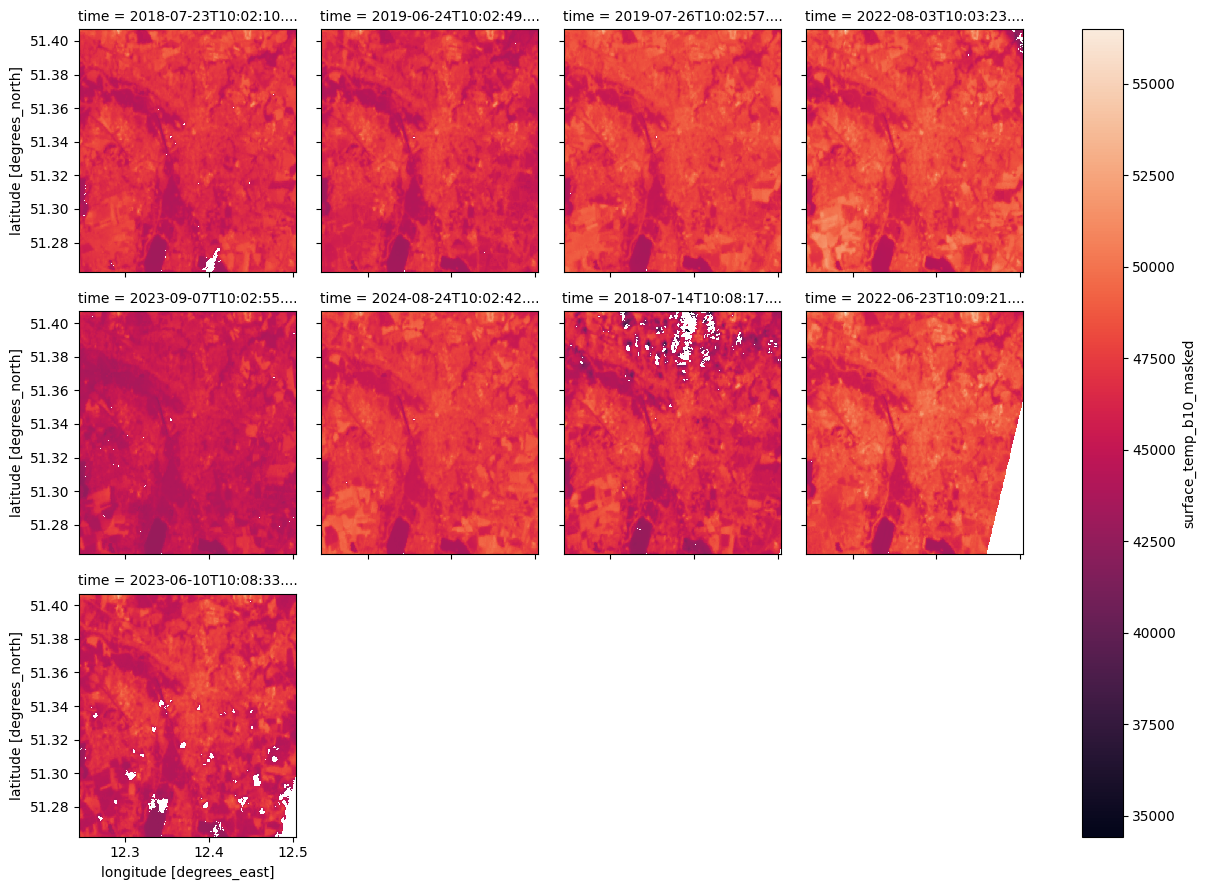

In [133]:
# filter out all timesteps where no data values are present
mask = landsat_xr_ds.surface_temp_b10_masked.notnull().compute()
landsat_xr_ds=landsat_xr_ds.where(mask, drop=True)

#filter where qa_pixel not more than max_cloud_cover percentage
valid_pixel_percentage = landsat_xr_ds.qa_pixel.notnull().mean(dim=['x', 'y']).compute()
landsat_xr_ds = landsat_xr_ds.where(valid_pixel_percentage >= (100-max_cloud_cover)/100, drop=True)

# facetgrid plot
landsat_xr_ds.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

We stored the scale factor and offset within the variables, which is why only after saving and reading in from zarr, the data plots with the correct scale:

In [134]:
#save as zarr dataset
landsat_zarr_name = f"{landsat_region_folder}/landsat_temperature_ge{min_temperature}_cc{max_cloud_cover}_{start_year}_{end_year}.zarr"
landsat_xr_ds.to_zarr(landsat_zarr_name, mode='w')

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\core\array.py:4699: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  serializer = VLenUTF8Codec()
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:43: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\api\asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


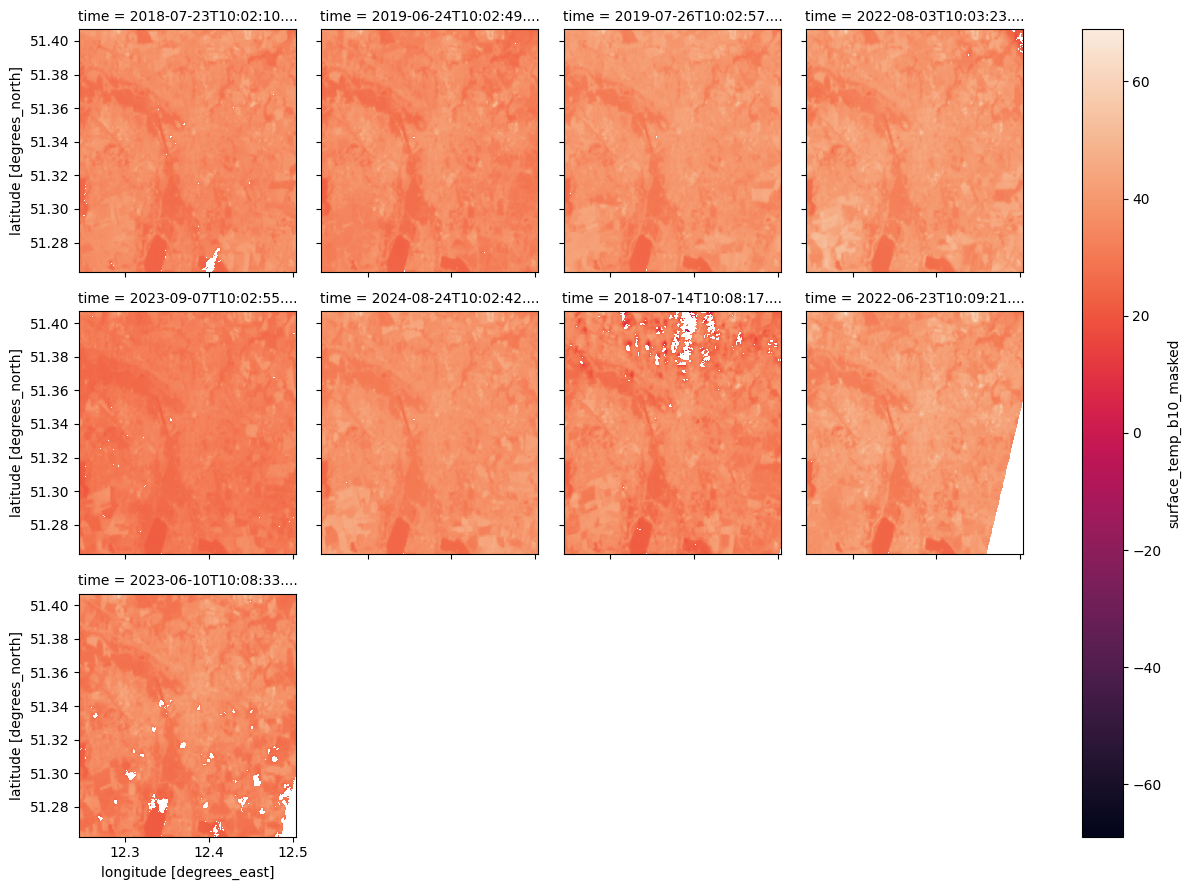

In [135]:
landsat_xr_ds=xr.open_zarr(landsat_zarr_name)
landsat_xr_ds.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)

In [136]:
landsat_xr_ds

<xarray.Dataset> Size: 111MB
Dimensions:                  (time: 9, y: 396, x: 710)
Coordinates:
  * y                        (y) float64 3kB 51.41 51.41 51.41 ... 51.26 51.26
  * x                        (x) float64 6kB 12.25 12.25 12.25 ... 12.5 12.5
  * time                     (time) object 72B '2018-07-23T10:02:10.415562Z' ...
Data variables:
    view_sun_azimuth         (time, y, x) float64 20MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
    view_off_nadir           (time, y, x) float64 20MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
    view_sun_elevation       (time, y, x) float64 20MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
    stac_id                  (time, y, x) object 20MB dask.array<chunksize=(9, 396, 710), meta=np.ndarray>
    surface_temp_b10         (time, y, x) float32 10MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
    qa_pixel                 (time, y, x) float32 10MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
    surface_temp_b10_masked  (time, y, x) float32 10MB dask.array<chunksize=(3, 99, 355), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Point
    title:          Landsat 8 Surface Temperature
    description:    Landsat 8 Surface Temperature data from USGS for specific...
    source:         USGS
    crs:            EPSG:4326
    bbox:           {"type": "FeatureCollection", "features": [{"id": "5157",...
    variables:      {'surface_temp_b10': 'Surface Temperature Band (B10)', 'q...
    units:          {'surface_temp_b10': '°C', 'qa_pixel': '1', 'surface_temp...

The zarr with temperatures greater 30 for comparison:

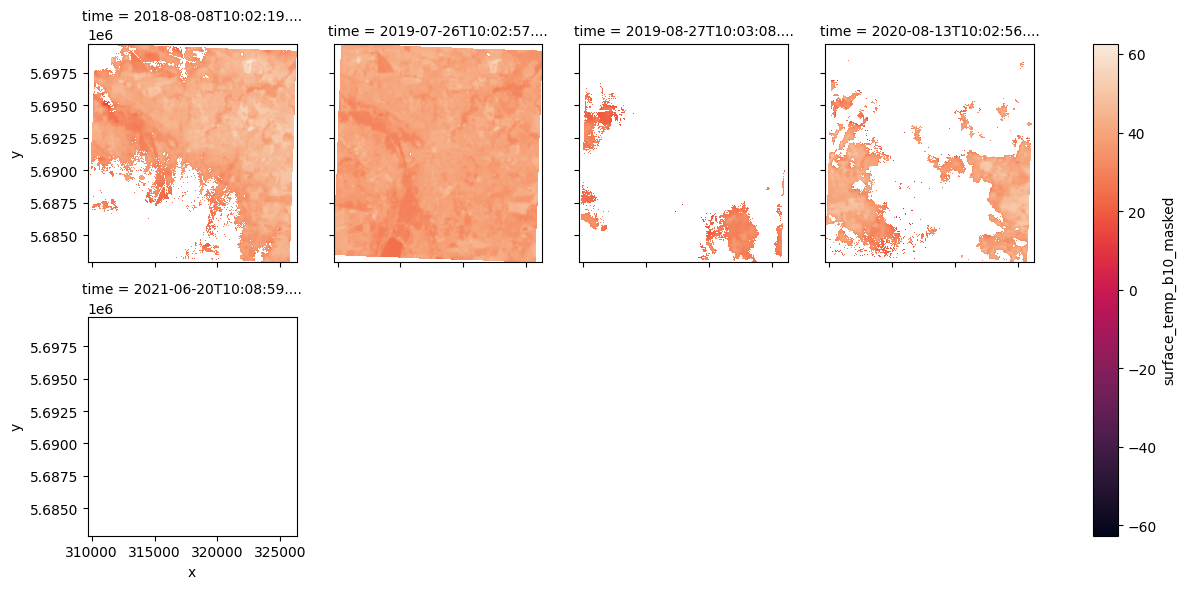

In [ ]:
landsat_xr_ds=xr.open_zarr(f"{repo_dir}/data/landsat/landsat_temperature_gt30_2018_2022.zarr")
landsat_xr_ds.surface_temp_b10_masked.plot(col='time', col_wrap=4, cmap=rocket)